In [25]:
import optax
import matplotlib.pyplot as plt

from jax.random import PRNGKey, split

from weight_uncertainty.priors import ScaleMixturePrior
from weight_uncertainty.elbo import build_elbo
from weight_uncertainty.training import build_elbo_train_loop
from weight_uncertainty.variational import MeanFieldLinearLayer, sample_predictive


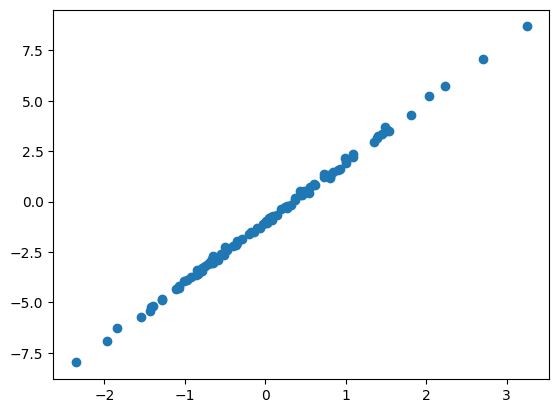

In [26]:
import numpy as np

xs = np.random.normal(size=(100,1))
noise = np.random.normal(scale=0.1, size=(100,1))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [27]:
prior_fn = ScaleMixturePrior(pi=0.5, var1=0.99, var2=0.01)
model = MeanFieldLinearLayer(features=1, logprior=prior_fn)

key = PRNGKey(123)
key, init_key1, init_key2 = split(key, num=3)
params = model.init(init_key1, {"key":init_key2}, xs[0])

key, subkey = split(key)
state = {"key": subkey}



In [28]:
elbo = build_elbo("regression")

opt = optax.sgd(learning_rate=0.003)
opt_state = opt.init(params)

train_loop = build_elbo_train_loop(elbo, opt, model, (xs, ys))
epochs = 300
kl_weight = 0.01
for i in range(epochs):
    params, state = train_loop(params, state, opt_state, kl_weight)

ELBO: 3.9278008937835693 | MSE: 3.9012954235076904 | KL penalty: 0.026505548506975174
ELBO: 0.5518847107887268 | MSE: 0.520697295665741 | KL penalty: 0.031187407672405243
ELBO: 5.120875835418701 | MSE: 5.113963603973389 | KL penalty: 0.006912012118846178
ELBO: 0.25276216864585876 | MSE: 0.2170068323612213 | KL penalty: 0.03575534373521805
ELBO: 6.998877048492432 | MSE: 7.000818729400635 | KL penalty: -0.0019417571602389216
ELBO: 4.32517147064209 | MSE: 4.3075151443481445 | KL penalty: 0.01765642687678337
ELBO: 2.8953917026519775 | MSE: 2.8726305961608887 | KL penalty: 0.022760998457670212
ELBO: 4.034332752227783 | MSE: 4.017085075378418 | KL penalty: 0.017247671261429787
ELBO: 6.27946662902832 | MSE: 6.268233299255371 | KL penalty: 0.011233296245336533
ELBO: 0.222085103392601 | MSE: 0.17859764397144318 | KL penalty: 0.043487463146448135
ELBO: 6.546136379241943 | MSE: 6.53676700592041 | KL penalty: 0.009369569830596447
ELBO: 4.061291217803955 | MSE: 4.04812479019165 | KL penalty: 0.0131

In [29]:
xs.shape

(100, 1)

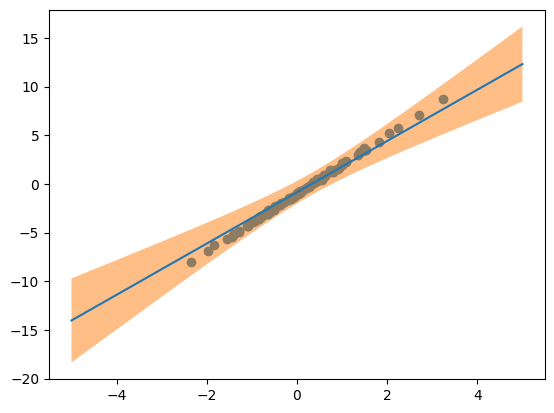

In [30]:
test_xs = np.linspace(-5, 5, 100)[..., np.newaxis]

logits_stacked, _ = sample_predictive(n_samples=15, model=model, init_state=state, params=params, x=test_xs)

logits_mean = logits_stacked.mean(axis=0)
logits_std = logits_stacked.std(axis=0)

plt.scatter(xs, ys);
plt.plot(test_xs, logits_mean);
plt.fill_between(test_xs.squeeze(), (logits_mean-2*logits_std).squeeze(), (logits_mean+2*logits_std).squeeze(), alpha=0.5);